In [223]:
from __future__ import absolute_import
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
import statsmodels.api as sm
import urllib2
import sys
import numpy as np

pl.rcParams['font.size'] = 20 
from pandas.io.json import json_normalize
%pylab inline

Populating the interactive namespace from numpy and matplotlib


###Data Resource
To find out the relationship between green space and incomes in Mahattan NYC, I download the data from the several resources below;  
1.The landuse data of each community in Manhattan, NYC.  
Data resource: DCP Community Portal  
Link: http://www.nyc.gov/html/dcp/html/neigh_info/nhmap.shtml  
2.The median household incomes in the past 12 months of New York State  
Data resource: American Community Surveys, 2013 ACS 5-year estimate  
Link: http://factfinder.census.gov/faces/nav/jsf/pages/download_center.xhtml  
3.PLUTO to switch the zipcode to community number  
Data resource: PLUTO and Map PULTO  
Link: http://www.nyc.gov/html/dcp/html/bytes/applbyte.shtml#pluto  

In [224]:
data1 = pd.read_csv('data/ACS_13_5YR_S1903_with_ann.csv')

In [225]:
dataT = pd.read_csv('data/Mn.csv')

In [226]:
dataLand = pd.read_csv('data/ManhattanLanduse.csv')

###Data Cleaning  
1.Use the PLUTO data to transfer the income I got from the Census data, since the income data is grouped by zipcode, I need to transfer the zipcode to community number and calculate the mean of Median Household income.  
2.Merge the transfered data with the landuse data.

In [227]:
dataT.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,MN,1,10,101,5,1018,2,1,10004,E007,...,190225,16a,Y,199 999,10101,,0,,1,15v1
1,MN,1,101,101,1,1001,2,1,10004,E007,...,190636,16a,Y,199 999,10101,,0,,1,15v1
2,MN,1,201,101,1,1000,2,1,10004,E007,...,193648,12b,,199 999,10101,,0,,1,15v1
3,MN,1,301,101,,,2,1,10004,E007,...,,12b,,199 999,10101,,0,,4,15v1
4,MN,1,401,101,,,2,1,10004,E007,...,,12b,,1 99 999,10101,,0,,4,15v1


In [228]:
df1 = pd.DataFrame(data=[dataT.CD,dataT.ZipCode]).T

In [229]:
df1.head()

,CD,ZipCode
0,101,10004
1,101,10004
2,101,10004
3,101,10004
4,101,10004


In [230]:
data1.head()

,GEO.id,GEO.id2,GEO.display-label,HC01_EST_VC02,HC01_MOE_VC02,HC02_EST_VC02,HC02_MOE_VC02,HC01_EST_VC04,HC01_MOE_VC04,HC02_EST_VC04,...,HC02_EST_VC39,HC02_MOE_VC39,HC01_EST_VC40,HC01_MOE_VC40,HC02_EST_VC40,HC02_MOE_VC40,HC01_EST_VC41,HC01_MOE_VC41,HC02_EST_VC41,HC02_MOE_VC41
0,Id,Id2,Geography,Total; Estimate; Households,Total; Margin of Error; Households,Median income (dollars); Estimate; Households,Median income (dollars); Margin of Error; Hous...,Total; Estimate; Households - One race-- - White,Total; Margin of Error; Households - One race-...,Median income (dollars); Estimate; Households ...,...,Median income (dollars); Estimate; PERCENT IMP...,Median income (dollars); Margin of Error; PERC...,Total; Estimate; PERCENT IMPUTED - Family inco...,Total; Margin of Error; PERCENT IMPUTED - Fami...,Median income (dollars); Estimate; PERCENT IMP...,Median income (dollars); Margin of Error; PERC...,Total; Estimate; PERCENT IMPUTED - Nonfamily i...,Total; Margin of Error; PERCENT IMPUTED - Nonf...,Median income (dollars); Estimate; PERCENT IMP...,Median income (dollars); Margin of Error; PERC...
1,8600000US06390,06390,ZCTA5 06390,121,41,149554,23979,100.0,23.3,149554,...,(X),(X),70.5,(X),(X),(X),0.0,(X),(X),(X)
2,8600000US10001,10001,ZCTA5 10001,11024,474,81671,8474,68.5,2.9,96810,...,(X),(X),24.9,(X),(X),(X),17.6,(X),(X),(X)
3,8600000US10002,10002,ZCTA5 10002,32467,571,33218,2320,38.3,1.6,57369,...,(X),(X),36.1,(X),(X),(X),29.3,(X),(X),(X)
4,8600000US10003,10003,ZCTA5 10003,27505,517,92540,4479,82.8,1.7,94530,...,(X),(X),23.5,(X),(X),(X),21.9,(X),(X),(X)


In [231]:
df2 = pd.DataFrame(data=[data1['GEO.id2'],data1['HC02_EST_VC02']]).T
df2 = df2.rename(columns={'GEO.id2':'ZipCode','HC02_EST_VC02':'MedianIncome'})

In [232]:
df2 = df2[1:]

In [233]:
df2.head()

,ZipCode,MedianIncome
1,06390,149554
2,10001,81671
3,10002,33218
4,10003,92540
5,10004,129313


In [234]:
#df2 = df2.set_index('ZipCode')

In [235]:
data = pd.merge(df1,df2,how='inner',on=['ZipCode'])

In [236]:
def isint(x):
    try: 
        int(x)
        return True
    except:
        return False

In [237]:
In=[]
for i in data.index:
    if isint(data['MedianIncome'][i]):
        In.append((data['CD'][i], int(data['MedianIncome'][i])))

In [238]:
In = pd.DataFrame(In)
Income = In[1].groupby(In[0]).mean()

In [239]:
dataLand.head()

,CB,1- 2 Family Residential,Multi-Family Residential,Mixed Resid. / Commercial,Commercial / Office,Industrial,Transportation / Utility,Institutions,Open Space / Recreation,Parking Facilities,Vacant Land,Miscellaneous
0,101,45.0,1983.2,3384.9,8379.8,379.2,4373.9,10233.3,1340.3,301.6,339.0,5778.6
1,102,920.2,6197.7,5228.0,4666.0,1121.5,4432.6,2307.0,1013.6,565.6,1246.2,73.7
2,103,108.1,11193.2,7587.2,1770.2,458.4,1472.5,3574.4,5364.2,308.7,1886.6,108.9
3,104,240.3,7523.7,5111.1,5355.8,1718.0,11504.6,3962.2,756.3,1653.5,2190.3,112.3
4,105,24.5,1921.5,2734.1,19017.9,1396.3,855.2,1563.0,948.4,467.1,289.9,16.3


In [240]:
dataLand['Total'] = dataLand.sum(axis=1)

In [241]:
dataLand['Income'] = 0
for i in dataLand['CB']:
    dataLand['Income'][i-101] = Income[i]

/Users/MISSZHOU/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [242]:
dataLand

,CB,1- 2 Family Residential,Multi-Family Residential,Mixed Resid. / Commercial,Commercial / Office,Industrial,Transportation / Utility,Institutions,Open Space / Recreation,Parking Facilities,Vacant Land,Miscellaneous,Total,Income
0,101,45.0,1983.2,3384.9,8379.8,379.2,4373.9,10233.3,1340.3,301.6,339.0,5778.6,36639.8,110552
1,102,920.2,6197.7,5228.0,4666.0,1121.5,4432.6,2307.0,1013.6,565.6,1246.2,73.7,27874.1,97517
2,103,108.1,11193.2,7587.2,1770.2,458.4,1472.5,3574.4,5364.2,308.7,1886.6,108.9,33935.4,57907
3,104,240.3,7523.7,5111.1,5355.8,1718.0,11504.6,3962.2,756.3,1653.5,2190.3,112.3,40232.1,89978
4,105,24.5,1921.5,2734.1,19017.9,1396.3,855.2,1563.0,948.4,467.1,289.9,16.3,29339.2,92051
5,106,415.2,6064.2,8049.2,3731.2,41.2,1642.0,4413.0,897.4,269.2,699.9,54.5,26383.0,102997
6,107,793.5,14588.9,6655.1,1587.7,30.2,1048.2,4146.2,7024.6,323.5,1686.1,7.3,37998.3,95429
7,108,2016.5,17771.9,8386.4,1613.6,142.3,899.7,5607.2,1408.7,277.9,382.3,64.0,38678.5,105232
8,109,607.9,7953.0,2225.7,770.0,332.1,1440.9,6105.2,9125.0,332.8,1368.7,2.8,30373.1,39901
9,110,934.9,10955.0,5630.9,1409.9,151.5,206.5,3733.4,1440.5,224.5,1000.4,24.3,25821.8,37189


###Data Analysis

In [243]:
import statsmodels
import statsmodels.formula.api as smf

Regression between the green open space area and the Median household income.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     8.682
Date:                Wed, 16 Dec 2015   Prob (F-statistic):             0.0146
Time:                        09:22:02   Log-Likelihood:                -136.95
No. Observations:                  12   AIC:                             277.9
Df Residuals:                      10   BIC:                             278.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   8.965e+04   8570.525     10.461      0.0

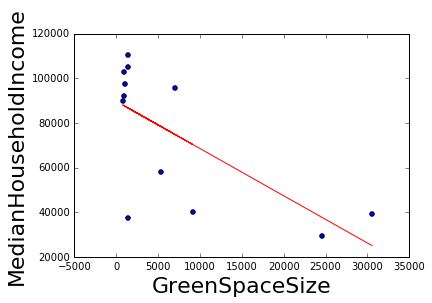

In [244]:
model1 = smf.ols(formula = 'y ~ x ', data={'x':dataLand['Open Space / Recreation'] , 'y': dataLand['Income']}).fit()
print model1.summary()

pl.scatter(dataLand['Open Space / Recreation'], dataLand['Income'])
pl.xlabel("GreenSpaceSize", fontsize=22)
pl.ylabel("MedianHouseholdIncome", fontsize=22)

dataLand['predict'] = model1.predict() 
plot(dataLand['Open Space / Recreation'], model1.predict(), '-', color='red')

Regression between the green space ratio and the Median household income.

In [246]:
dataLand['GreenRatio'] = 0

for i in dataLand.index:
    dataLand['GreenRatio'].iloc[i]=float(dataLand['Open Space / Recreation'].iloc[i])/dataLand['Total'][i]

In [247]:
dataLand

,CB,1- 2 Family Residential,Multi-Family Residential,Mixed Resid. / Commercial,Commercial / Office,Industrial,Transportation / Utility,Institutions,Open Space / Recreation,Parking Facilities,Vacant Land,Miscellaneous,Total,Income,predict,GreenRatio
0,101,45.0,1983.2,3384.9,8379.8,379.2,4373.9,10233.3,1340.3,301.6,339.0,5778.6,36639.8,110552,86818.056136,0.036580
1,102,920.2,6197.7,5228.0,4666.0,1121.5,4432.6,2307.0,1013.6,565.6,1246.2,73.7,27874.1,97517,87509.171763,0.036364
2,103,108.1,11193.2,7587.2,1770.2,458.4,1472.5,3574.4,5364.2,308.7,1886.6,108.9,33935.4,57907,78305.720135,0.158071
3,104,240.3,7523.7,5111.1,5355.8,1718.0,11504.6,3962.2,756.3,1653.5,2190.3,112.3,40232.1,89978,88053.475561,0.018798
4,105,24.5,1921.5,2734.1,19017.9,1396.3,855.2,1563.0,948.4,467.1,289.9,16.3,29339.2,92051,87647.098726,0.032325
5,106,415.2,6064.2,8049.2,3731.2,41.2,1642.0,4413.0,897.4,269.2,699.9,54.5,26383.0,102997,87754.986381,0.034014
6,107,793.5,14588.9,6655.1,1587.7,30.2,1048.2,4146.2,7024.6,323.5,1686.1,7.3,37998.3,95429,74793.236551,0.184866
7,108,2016.5,17771.9,8386.4,1613.6,142.3,899.7,5607.2,1408.7,277.9,382.3,64.0,38678.5,105232,86673.359751,0.036421
8,109,607.9,7953.0,2225.7,770.0,332.1,1440.9,6105.2,9125.0,332.8,1368.7,2.8,30373.1,39901,70349.957509,0.300430
9,110,934.9,10955.0,5630.9,1409.9,151.5,206.5,3733.4,1440.5,224.5,1000.4,24.3,25821.8,37189,86606.088625,0.055786


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     8.682
Date:                Wed, 16 Dec 2015   Prob (F-statistic):             0.0146
Time:                        09:22:59   Log-Likelihood:                -136.95
No. Observations:                  12   AIC:                             277.9
Df Residuals:                      10   BIC:                             278.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   8.965e+04   8570.525     10.461      0.0

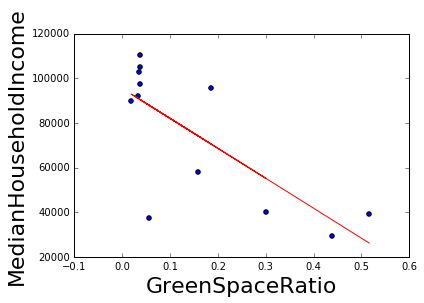

In [248]:
model2 = smf.ols(formula = 'y ~ x ', data={'x':dataLand['GreenRatio'] , 'y': dataLand['Income']}).fit()
print model1.summary()

pl.scatter(dataLand['GreenRatio'], dataLand['Income'])
pl.xlabel("GreenSpaceRatio", fontsize=22)
pl.ylabel("MedianHouseholdIncome", fontsize=22)

dataLand['predict2'] = model2.predict() 
plot(dataLand['GreenRatio'], model2.predict(), '-', color='red')